**Problem 3**

In [2]:

# Useful additional packages 
import matplotlib.pyplot as plt
import numpy as np
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
import torch




"""
q = QuantumRegister(2)

qc = QuantumCircuit(q)
qc.u(pi,0,pi,q[0])
qc.draw()
"""


#lets create GHZ state
circ = QuantumCircuit(3)
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
circ.cx(0, 2)
# Set the intial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**3)
state1 = state.copy()
# Evolve the state by the quantum circuit
state = state.evolve(circ)
print(state)
print(state1)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


In [3]:
#function that apply the KS test to two probability list
def KS(P1, P2):
    assert len(P1) == len(P2)
    cdf1 = [P1[0]]
    cdf2 = [P2[0]]
    for i in range(len(P1)-1):
        cdf1.append(cdf1[i] + P1[i+1])
        cdf2.append(cdf2[i] + P2[i+1])
    difference = torch.tensor(cdf1) - torch.tensor(cdf2)
    #print(difference)
    return difference.abs().max().item()

print(KS([0.2, 0.8], [0.5, 0.5]))

0.30000001192092896


In [4]:
q = QuantumRegister(3)
qc = QuantumCircuit(q)
qc.u(0.5,0,pi,q[0])
qc.u(0.5,0,pi,q[1])
qc.u(0.5,0,pi,q[2])

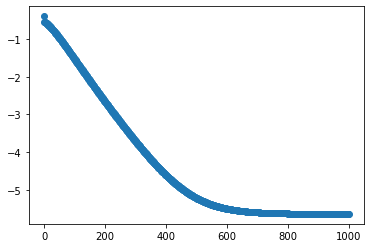

In [6]:
#this is where we try to learn the symmetry

class SymFinder():
  def __init__(self, eta, step_size):
      self.theta0 = 2
      self.theta1 = 0.5
      self.theta2 = 2.4
      self.original_state = state
      self.transformed_state = None
      self.lr = eta
      self.step_size = step_size
      self.losses = []

  
  #return a transformed state according to parameter
  def transform(self, theta0, theta1, theta2):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    qc.u(theta0,0,pi,q[0])
    qc.u(theta1,0,pi,q[1])
    qc.u(theta2,0,pi,q[2])
    return self.original_state.copy().evolve(qc)
  
  
  #return the loss from KS test of original vs another state
  def calculate_loss(self, state2):
    P1 = self.original_state.probabilities()
    P2 = state2.probabilities()
    return KS(P1, P2)
  
  def update(self):
    #calculate the gradient using good old finite difference:
    cur_state = self.transform(self.theta0, self.theta1, self.theta1)
    state0 = self.transform(self.theta0 + self.step_size, self.theta1, self.theta1)
    state1 = self.transform(self.theta0, self.theta1 + self.step_size, self.theta1)
    state2 = self.transform(self.theta0, self.theta1, self.theta1 + self.step_size)
    cur_loss = self.calculate_loss(cur_state)
    loss0 = self.calculate_loss(state0)
    loss1 = self.calculate_loss(state1)
    loss2 = self.calculate_loss(state2)
    grad0 = (loss0 - cur_loss) / self.step_size
    grad1 = (loss1 - cur_loss) / self.step_size
    grad2 = (loss2 - cur_loss) / self.step_size
    #update the parameters:
    self.theta0 = self.theta0 - self.lr * grad0
    self.theta1 = self.theta2 - self.lr * grad1
    self.theta2 = self.theta2 - self.lr * grad2
    return cur_loss
  
  def train(self):
    for i in range(1000):
      self.losses.append(self.update())
      #print(self.losses[i])



model = SymFinder(0.05, 0.005)
model.train()

import numpy as np

plt.scatter(range(len(model.losses)), np.log10(model.losses))
plt.show()


  

  

  
  
  

  


In [40]:
print(model.theta0, model.theta1, model.theta2)

3.136588358690996 3.1365907307943854 3.1365907307943854
